In [1]:
import os
import MRzeroCore as mr0
import torch
import numpy as np
import matplotlib.pyplot as plt
import pypulseq as pp
from scipy.io import loadmat
%matplotlib widget


/mnt/DATA2/USCOneDrive/codebase/pulseq_sequences/rt_spiral/venv/lib/python3.12/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


Sequence signature: 30ce9858f3dbe711ec5399adf6ec512e
Volunteer data exists
VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])
Plotting slice 8 / 16


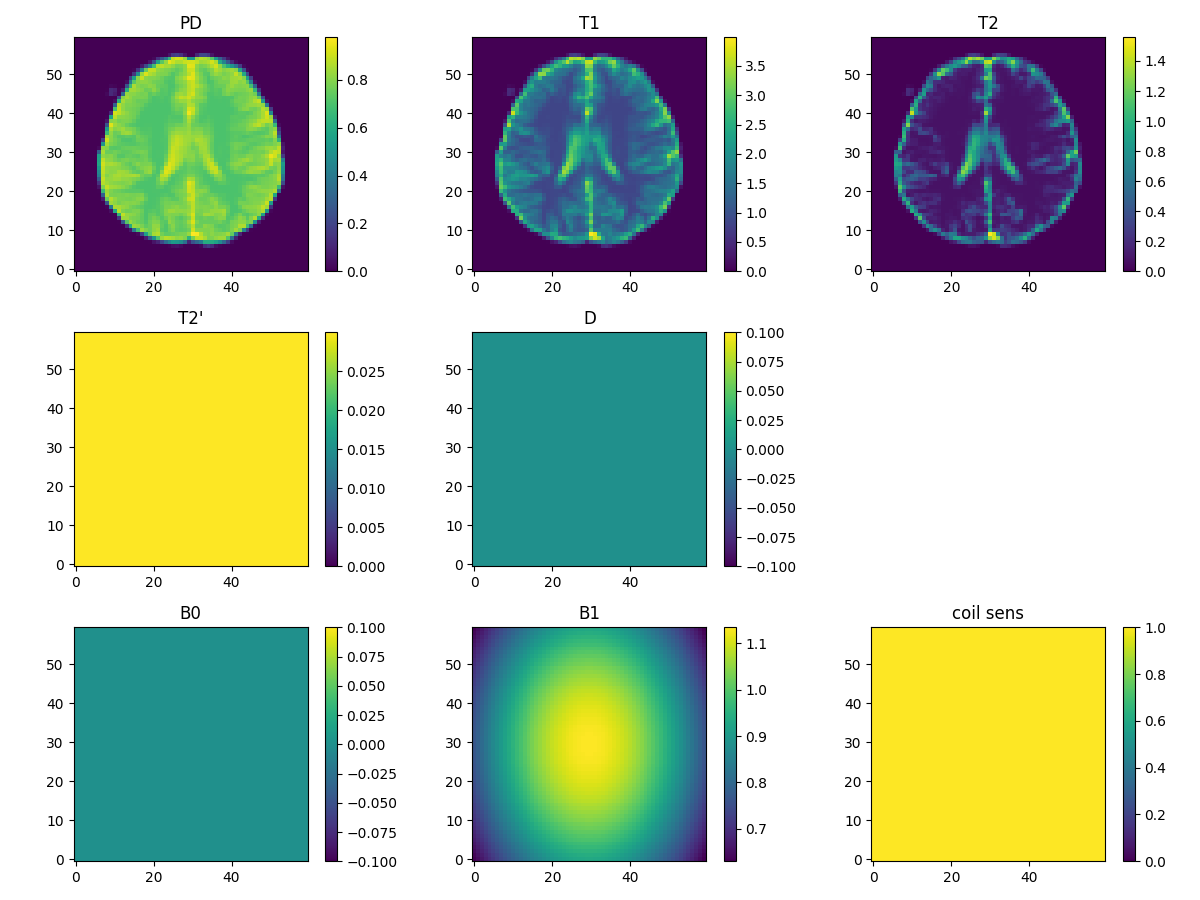

In [2]:
seq_path = os.path.join('out_seq', 'spiral_3D_linear_stack_trueFISP_linear45.0_nTR128_Tread3.00_TR10.96ms_FA12.seq')
seqp = pp.Sequence()
seqp.read(seq_path)
print('Sequence signature: ' + seqp.signature_value)
traj_name = seqp.signature_value
# Load the metadata
traj = loadmat("out_trajectory/" + traj_name)

n_unique_angles = traj['param']['interleaves'][0,0][0,0]

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
kz = traj['kz'][:,:]
pre_discard = traj['param']['pre_discard'][0,0][0,0]

Nkz = int(traj['param']['matrix_size'][0,0][0,2])
Nread = kx.shape[0]
Nphase = n_unique_angles
n_eco = 1

# WARNING: Will load a lot of volunteer data
# 3D Brain Phantom from BrainWeb. 
# Run this once to save the phantom in a np file
if os.path.exists('brainweb/'):
    print("Volunteer data exists")
else:
    mr0.generate_brainweb_phantoms("brainweb", "3T")

sz = [int(traj['param']['matrix_size'][0,0][0,0]), int(traj['param']['matrix_size'][0,0][0,1]), int(traj['param']['matrix_size'][0,0][0,2])]    # spin system size / resolution
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above

# (i) load a phantom object from file
phantom_fn = 'brainweb/subject04_3T.npz'
obj_p = mr0.VoxelGridPhantom.brainweb(phantom_fn)
obj_p = obj_p.interpolate(sz[0], sz[1], sz[2])
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 0

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

In [3]:
seq0 = mr0.Sequence.import_file(seq_path)

# seq0.plot_kspace_trajectory()
kspace_loc = seq0.get_kspace()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0.cuda(), obj_p.cuda(), print_progress=True).cpu()


>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.003092707 s
Compute Graph
Computing Graph: 6.8724976 s
Analyze Graph
Analyzing Graph: 0.004762638 s
Converting Rust -> Python: 0.059230752 s
<<<< Rust <<<<
Calculating repetition 55 / 158

OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB. GPU 0 has a total capacity of 3.63 GiB of which 444.44 MiB is free. Including non-PyTorch memory, this process has 3.14 GiB memory in use. Of the allocated memory 2.28 GiB is allocated by PyTorch, and 810.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:

# PLOT sequence with signal in the ADC subplot
# sp_adc, t_adc = mr0.util.pulseq_plot(seqp, clear=True, signal=signal.numpy())

kspace_adc = torch.reshape((signal), (-1, Nread + pre_discard)).clone().t()
kspace_loc = torch.reshape(kspace_loc, (-1, Nread + pre_discard, 4)).clone()
kspace_step_1 = traj['param']['kspace_step_1'][0,0].T
kspace_step_2 = traj['param']['kspace_step_2'][0,0].T
contrast = traj['param']['contrast'][0,0].T
nTR = kspace_step_1.shape[0]
kspace_rsp = np.zeros((Nkz, Nphase, Nread+pre_discard, n_eco), dtype=np.complex64)
for ii in range(nTR):
    kspace_rsp[kspace_step_2[ii], kspace_step_1[ii], :, contrast[ii]] = kspace_adc[:, ii].numpy()


In [5]:
kspace_adc = torch.reshape((signal), (-1, Nread + pre_discard)).clone().t()
kspace_adc = kspace_adc = kspace_adc[:, 128:]
kspace_adc = kspace_adc.reshape(Nphase//2, Nkz, -1)

RuntimeError: shape '[136, 1510]' is invalid for input of size 386560

In [14]:

ktraj = np.stack((kx, -ky), axis=2)

# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))

# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)

msize = np.int16(10 * traj['param']['fov'][0,0][0,0] / traj['param']['spatial_resolution'][0,0][0,0])

ktraj = 0.5 * (ktraj / kmax) * msize

w = traj['w']
w = np.reshape(w, (1,w.shape[1]))

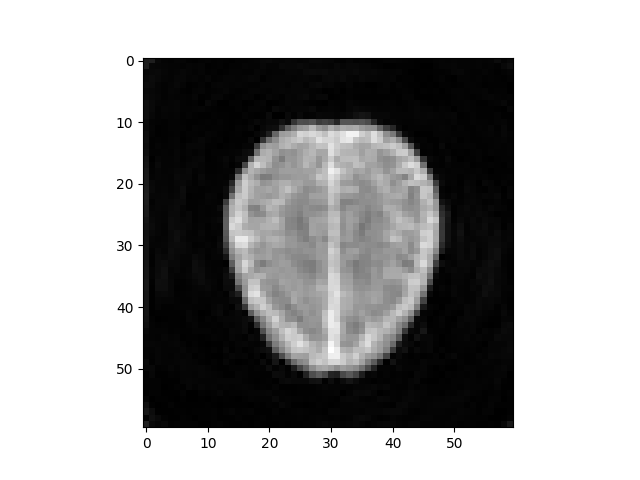

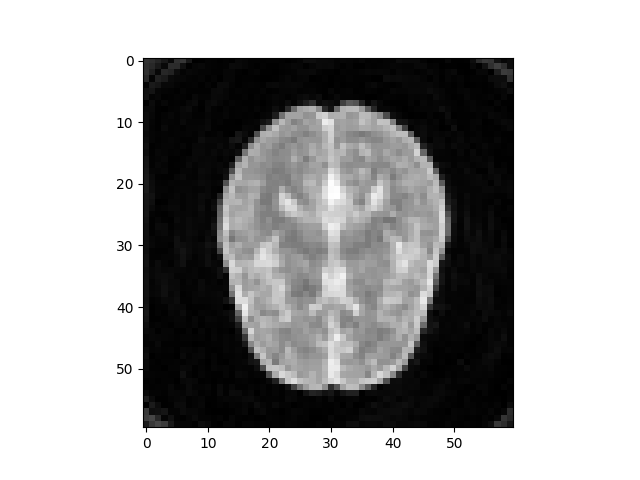

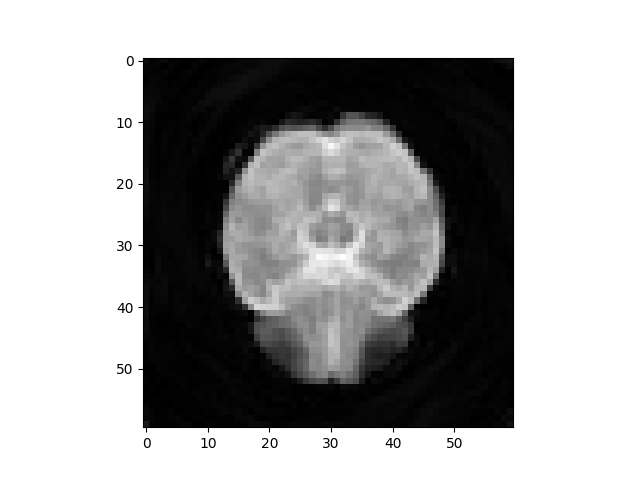

In [17]:
import sigpy as sp
from sigpy import fourier

ksp_slc = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(kspace_rsp, axes=(0)), axis=0), axes=0)
# ksp_slc = np.array(kspace_adc)
ksp_slc = ksp_slc.transpose(1, 2, 0, 3)
nchannel = 1
# Reconstruct
gpu_device = 0
device = sp.Device(gpu_device)

coord_gpu = sp.to_device(ktraj, device=device)
w_gpu = sp.to_device(w, device=device)

frames = []
images = []
for eco_idx in range(n_eco):
        for slc_idx in range(Nkz):

                kspace_ = ksp_slc[:,:,slc_idx, eco_idx].T
                for arm_counter, arm in enumerate(kspace_.T[:,:]):
                        adata = sp.to_device(arm[pre_discard:, None].T, device=device)
                        frames.append(fourier.nufft_adjoint(
                                adata*w_gpu,
                                coord_gpu[arm_counter%n_unique_angles,:,:],
                                (nchannel, msize, msize)))
                        if (arm_counter % (n_unique_angles-1) == 0) and (arm_counter > 0):
                                image = np.sum([sp.to_device(frame) for frame in frames], axis=0).squeeze()
                                images.append(image)
                                frames = []

# image = np.sum([sp.to_device(frame) for frame in frames], axis=0).squeeze()

plt.figure()
plt.imshow(np.abs(images[10]).T, cmap='gray')
plt.figure()
plt.imshow(np.abs(images[6]).T, cmap='gray')
plt.figure()
plt.imshow(np.abs(images[2]).T, cmap='gray')

In [14]:
traj['param']

array([[(array([[26]]), array([[2.]]), array([[84]]), array([[21]]), array([[17.14285714]]), array([[130., 130.]]), array([[10]]), array([[2.e-06]]))]],
      dtype=[('fov', 'O'), ('spatial_resolution', 'O'), ('repetitions', 'O'), ('interleaves', 'O'), ('ga_rotation', 'O'), ('matrix_size', 'O'), ('pre_discard', 'O'), ('dt', 'O')])